# Importing Libraries and getting url

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve
from sklearn.metrics import auc, classification_report, confusion_matrix
from sklearn import tree, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.externals.six import StringIO 
import xgboost as xgb
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA  
from Functionss import plot_corr_matrix, print_metrics, find_best_k, roc, plot_feature_importances
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
with open('df.pickle','rb') as file:
    fulldf=pickle.load(file)

In [69]:
features=fulldf.drop(columns=['name','type'])
trainn=fulldf.drop(columns='name')
selectedfeatures=['thc','Relaxed','Hungry','Sleepy','Depression','Insomnia','Pain','Euphoric','Creative','Energetic','Dry Mouth','Nausea','Uplifted','Fatigue','Focused']
# target=label_binarize(fulldf.type,classes=[0,1,2])
target=fulldf.type
# n_classes=target.shape[1]
                    
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,random_state=42)
trainx=X_train[selectedfeatures]
testx=X_test[selectedfeatures]

## PCA ??? CONFUSED

# DO THIS RIGHT!!

In [70]:
pca = PCA()
features=fulldf.drop(columns='name')
transformed = pca.fit_transform(features)

In [71]:
# plt.scatter(transformed[:,0], transformed[:,1],hue='ty');
pca.components_
pcadict={'feat1':transformed[:,0],'feat2':transformed[:,1]}

In [72]:
pcadf=pd.DataFrame(pcadict)

In [73]:
pcadf['target']=fulldf['type']
pcadf

,feat1,feat2,target
0,11.434610,0.964248,1
1,3.384114,-0.879409,2
2,-4.623586,-1.595153,2
3,6.345836,-2.059449,2
4,3.445988,0.732524,2
5,-9.628340,-1.045052,1
6,-0.631371,-1.370067,1
7,6.361583,-2.037468,2
8,-0.487268,2.876882,2
9,6.481758,1.912625,2


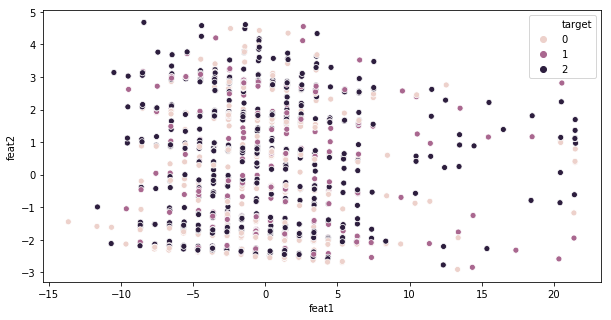

In [75]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='feat1',y='feat2',hue='target',data=pcadf)
plt.savefig('PCAPlot.png', bbox_inches='tight')

In [76]:
pca.mean_

array([1.2e+00, 7.8e-01, 2.0e-01, 8.6e-01, 2.9e-01, 4.7e-01, 8.2e-01,
       4.5e-01, 7.9e-01, 9.0e-01, 3.6e-01, 7.3e-01, 3.6e-01, 3.1e-01,
       1.1e-01, 7.7e-01, 2.2e-01, 3.1e-01, 6.1e-01, 8.5e-02, 4.2e-01,
       7.8e-02, 6.6e-01, 3.6e-01, 3.2e-01, 1.7e-01, 2.4e-01, 8.6e-02,
       3.1e-01, 1.2e-01, 5.8e-02, 1.8e-01, 1.9e-02, 8.0e-03, 4.8e+00,
       2.6e+00, 5.1e+00, 2.1e+01])

In [77]:
#put loading scores as a dataframe.apply to calculate each row

## Train Test Split

In [85]:
features=fulldf.drop(columns=['name','type'])
trainn=fulldf.drop(columns='name')
selectedfeatures=['thc','Relaxed','Hungry','Sleepy','Depression','Insomnia','Pain','Euphoric','Creative','Energetic','Dry Mouth','Nausea','Uplifted','Fatigue','Focused']
# target=label_binarize(fulldf.type,classes=[0,1,2])
target=fulldf.type
# n_classes=target.shape[1]
                    
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,random_state=42)
trainx=X_train[selectedfeatures]
testx=X_test[selectedfeatures]

In [86]:
featurespca=pcadf.drop(columns='target')
targetpca=pcadf.target
Xptrain, Xptest, yptrain, yptest = train_test_split(featurespca, targetpca, test_size=0.25,random_state=42)

## Scale & Select Features 

In [80]:
scaler = StandardScaler()

scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=features.columns)

### Scale Selected Features:

In [81]:
scaled_data_trainsel = scaler.fit_transform(trainx)
df_test = scaler.transform(testx)

df_train = pd.DataFrame(scaled_data_trainsel, columns=trainx.columns)

## Converting types

In [82]:
for i in fulldf['type']:
    i=float(i)
relax=[]
for i in fulldf['Relaxed']:
    relax.append(float(i))

## Looking at distributions of each effect before and after scaling

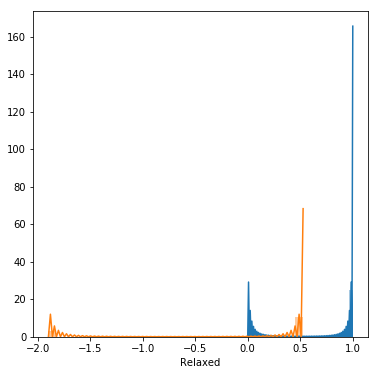

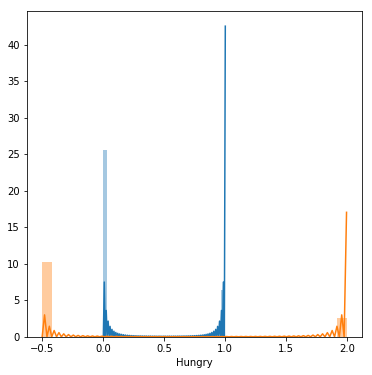

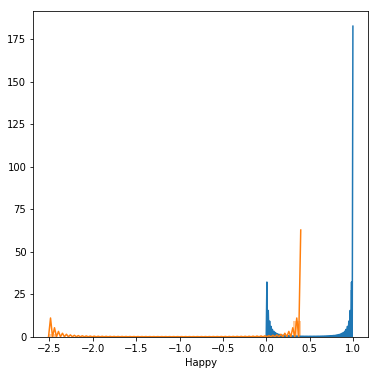

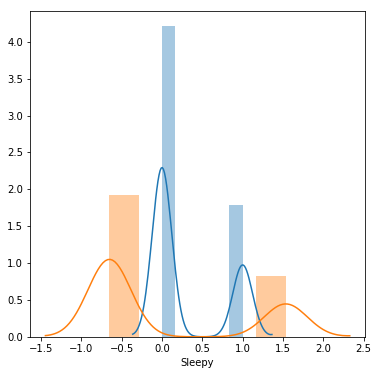

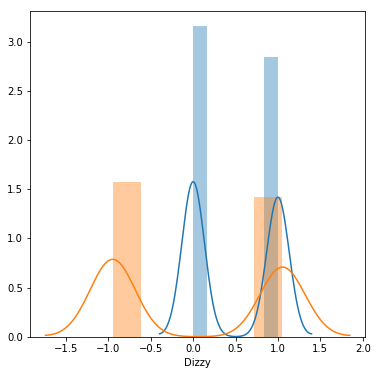

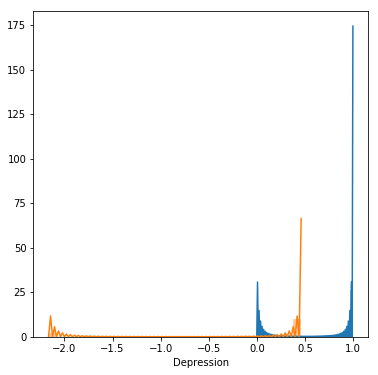

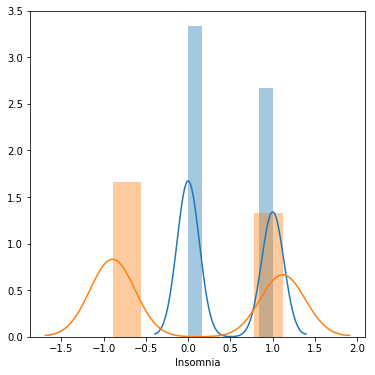

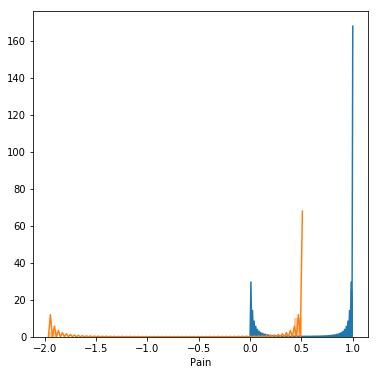

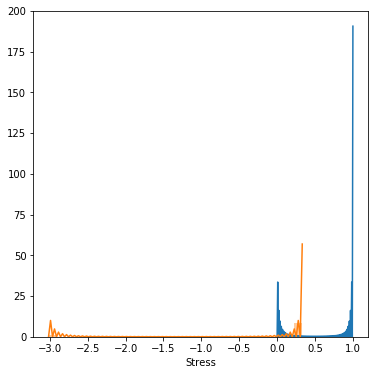

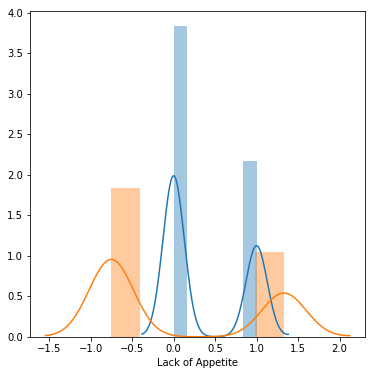

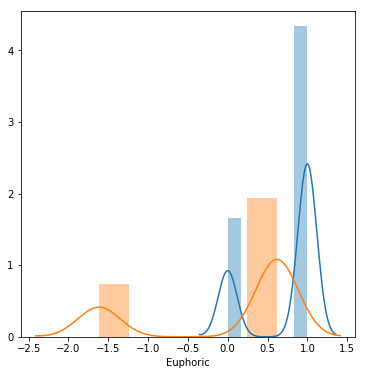

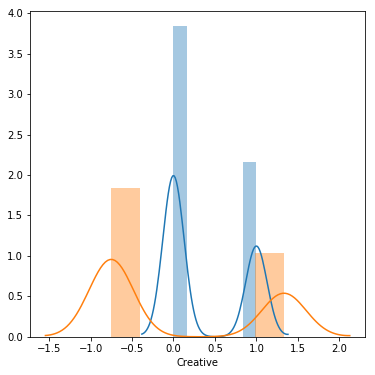

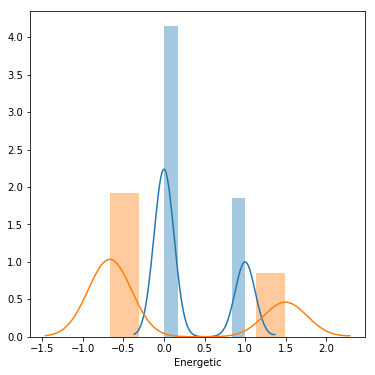

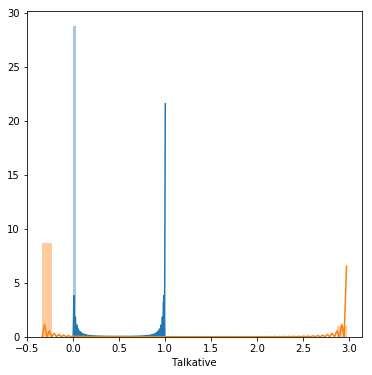

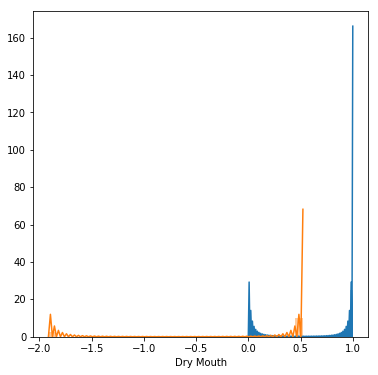

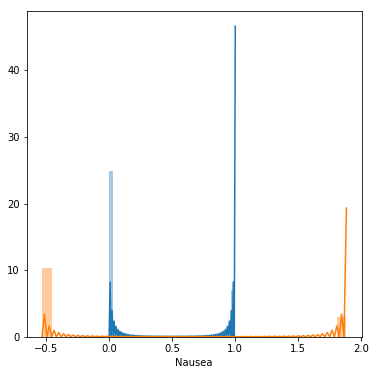

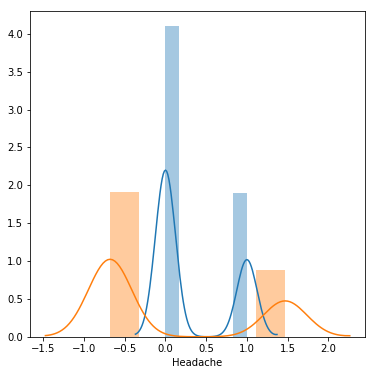

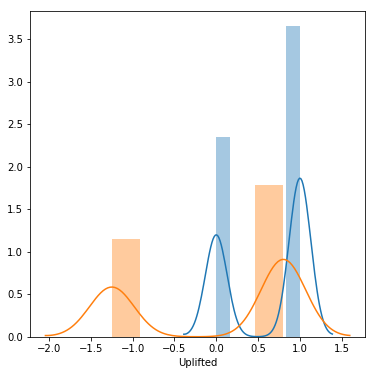

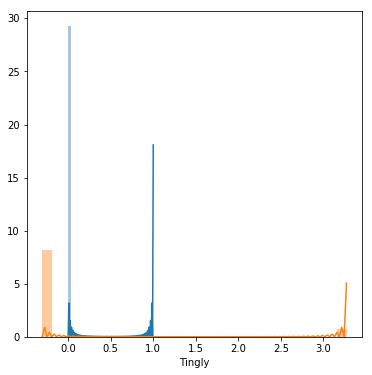

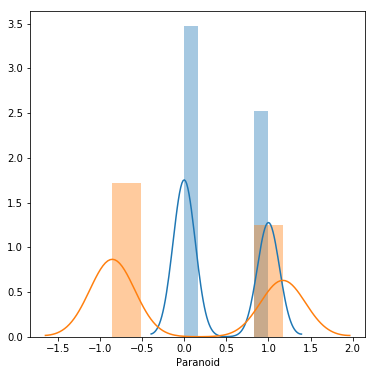

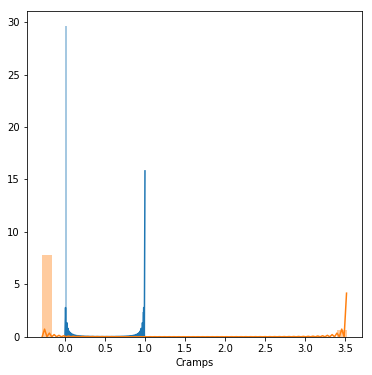

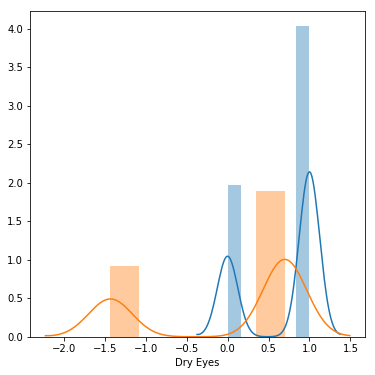

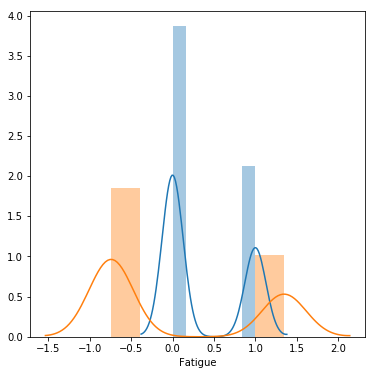

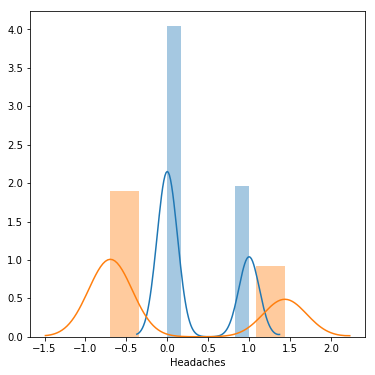

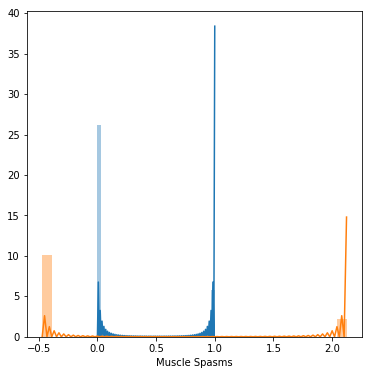

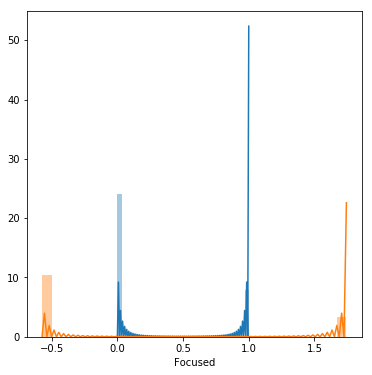

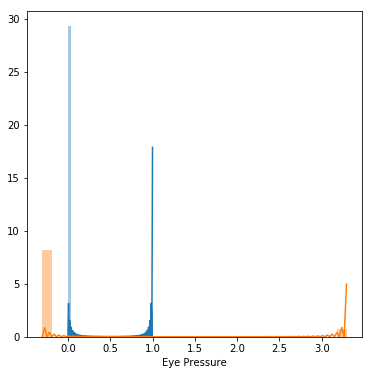

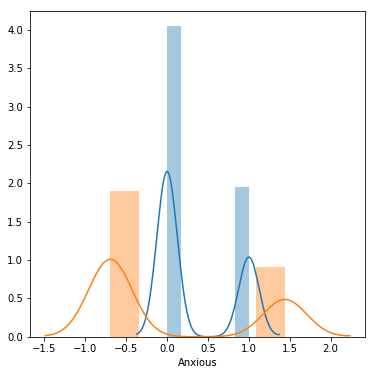

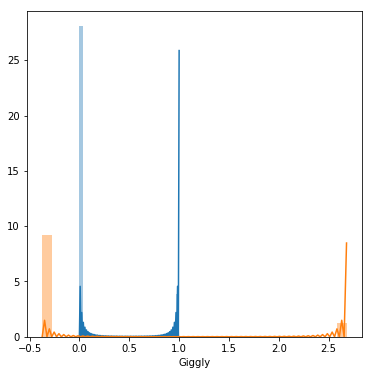

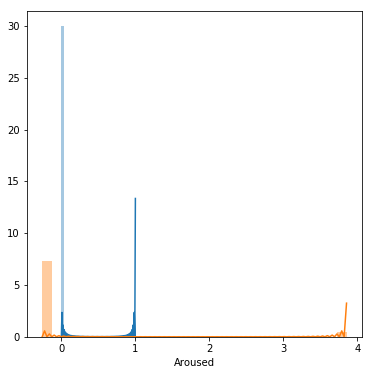

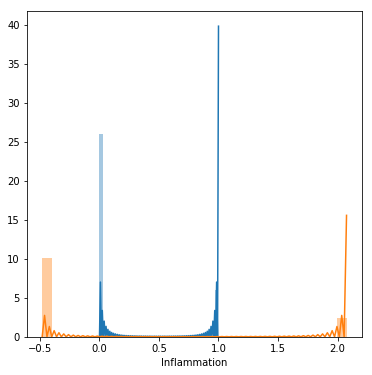

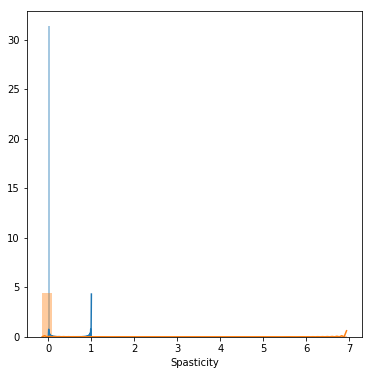

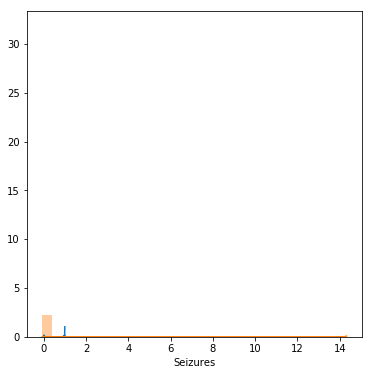

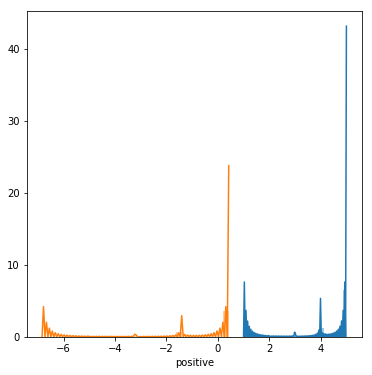

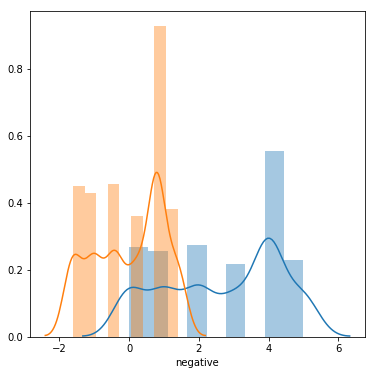

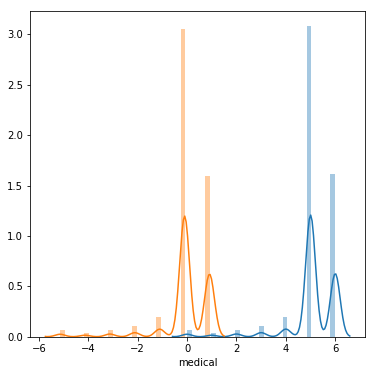

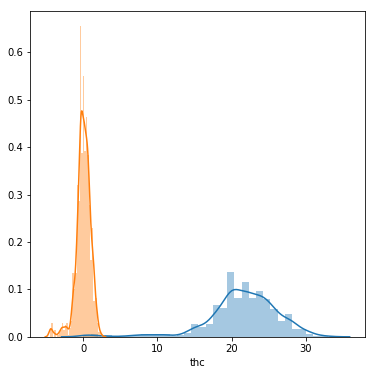

In [83]:
effects=fulldf.drop(columns=['name','type']).columns
for e in effects:
    plt.figure(figsize=(6,6))
    sns.distplot(X_train[e])
    sns.distplot(scaled_df_train[e])

# Beginning Modeling

## Baseline Model: Most probable to be hybrid, so predict all as hybrid

Baseline Model Metrics:
Precision Score: [0.  0.  0.6]
Recall Score: [0. 0. 1.]
Accuracy Score: 0.5784883720930233
F1 Score: [0.  0.  0.7]
Predicted    2  All
True               
0           91   91
1           54   54
2          199  199
All        344  344
              precision    recall  f1-score   support

      indica       0.00      0.00      0.00        91
      satica       0.00      0.00      0.00        54
      hybrid       0.58      1.00      0.73       199

   micro avg       0.58      0.58      0.58       344
   macro avg       0.19      0.33      0.24       344
weighted avg       0.33      0.58      0.42       344



<Figure size 720x432 with 0 Axes>

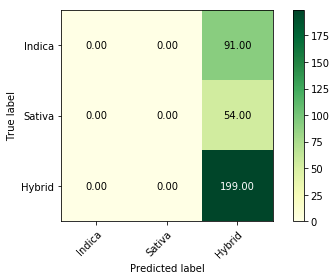

In [91]:
dummy = DummyClassifier(strategy='most_frequent', random_state=1)

dummy.fit(scaled_data_train, y_train)
basepreds=dummy.predict(scaled_data_test)
sc=dummy.score(scaled_data_test, y_test) 
print("Baseline Model Metrics:")
print_metrics(y_test,basepreds)
plt.figure(figsize=(10,6))
plot_corr_matrix(y_test,basepreds,['Indica','Sativa','Hybrid'],'Baseline')
plt.savefig('BaselineConfuseMatrix.png', bbox_inches='tight')
print(classification_report(y_test,basepreds,target_names=['indica','satica','hybrid']))

## Logistic Regression Model

Precision Score: [0.7 0.5 0.7]
Recall Score: [0.6 0.4 0.8]
Accuracy Score: 0.6627906976744186
F1 Score: [0.6 0.5 0.7]
Predicted   0   1    2  All
True                       
0          55   0   36   91
1           0  22   32   54
2          28  20  151  199
All        83  42  219  344
              precision    recall  f1-score   support

      indica       0.66      0.60      0.63        91
      satica       0.52      0.41      0.46        54
      hybrid       0.69      0.76      0.72       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.63      0.59      0.60       344
weighted avg       0.66      0.66      0.66       344



<Figure size 720x432 with 0 Axes>

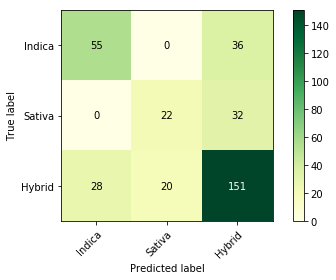

In [35]:
logreg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial') #Starter code
# Your code here
model_log = logreg.fit(scaled_data_train, y_train)
y_pred=model_log.predict(scaled_data_test)
print_metrics(y_test,y_pred)
plt.figure(figsize=(10,6))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('LogisticConfuseMatrix.png', bbox_inches='tight')
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))

## With PCA

Precision Score: [0.  0.  0.6]
Recall Score: [0. 0. 1.]
Accuracy Score: 0.5784883720930233
F1 Score: [0.  0.  0.7]
Predicted    2  All
True               
0           91   91
1           54   54
2          199  199
All        344  344
              precision    recall  f1-score   support

      indica       0.00      0.00      0.00        91
      satica       0.00      0.00      0.00        54
      hybrid       0.58      1.00      0.73       199

   micro avg       0.58      0.58      0.58       344
   macro avg       0.19      0.33      0.24       344
weighted avg       0.33      0.58      0.42       344



<Figure size 720x432 with 0 Axes>

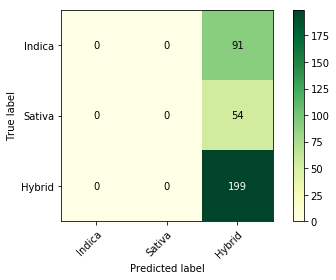

In [36]:
logreg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial') #Starter code
# Your code here
model_log = logreg.fit(Xptrain, yptrain)
y_pred=model_log.predict(Xptest)
print_metrics(yptest,y_pred)
plt.figure(figsize=(10,6))
plot_corr_matrix(yptest,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('LogisticPCAConfuseMatrix.png', bbox_inches='tight')
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))

In [19]:
y_hat_test = logreg.predict(scaled_data_test)
y_hat_train = logreg.predict(scaled_data_train)
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0    675
-1    114
-2     90
 2     83
 1     68
Name: type, dtype: int64
 0    0.655340
-1    0.110680
-2    0.087379
 2    0.080583
 1    0.066019
Name: type, dtype: float64


In [20]:
mat=confusion_matrix(y_hat_test,y_test)

In [21]:
ps=[]
i=0.0
for x in range(0,10):
    i+=0.1
    ps.append(i)

In [22]:
ps

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999]

In [23]:
logittpr,logitfpr=[],[]
for p in ps:
    mat=confusion_matrix(y_hat_test,y_test)
    logittpr.append(mat[0][0]+mat[1][1]+mat[2][2])

## KNN Base Model

In [24]:
clf1 = KNeighborsClassifier()
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.5 0.5 0.7]
Recall Score: [0.6 0.5 0.6]
Accuracy Score: 0.5755813953488372
F1 Score: [0.6 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.50      0.63      0.55        91
      satica       0.45      0.52      0.48        54
      hybrid       0.68      0.57      0.62       199

   micro avg       0.58      0.58      0.58       344
   macro avg       0.54      0.57      0.55       344
weighted avg       0.59      0.58      0.58       344



Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


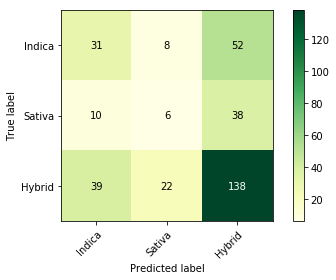

In [232]:
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])

### With Selected Features:

In [233]:
clf1 = KNeighborsClassifier()
clf1.fit(df_train, y_train)
test_preds = clf1.predict(df_test)
print_metrics(y_test, test_preds)
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))
confusion_matrix(test_preds,y_test)

Precision Score: [0.6 0.4 0.7]
Recall Score: [0.6 0.5 0.6]
Accuracy Score: 0.5988372093023255
F1 Score: [0.6 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.57      0.62      0.59        91
      satica       0.42      0.52      0.46        54
      hybrid       0.68      0.61      0.65       199

   micro avg       0.60      0.60      0.60       344
   macro avg       0.56      0.58      0.57       344
weighted avg       0.61      0.60      0.60       344



array([[ 56,   2,  40],
       [  2,  28,  37],
       [ 33,  24, 122]])

Predicted   0   1    2  All
True                       
0          56   2   33   91
1           2  28   24   54
2          40  37  122  199
All        98  67  179  344


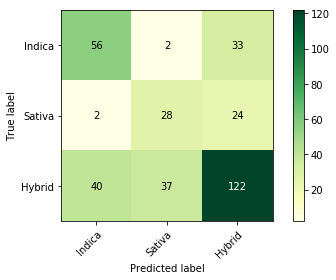

In [234]:
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])

### With PCA

In [28]:
clf1 = KNeighborsClassifier()
clf1.fit(Xptrain, yptrain)
test_preds = clf1.predict(Xptest)
print_metrics(yptest, test_preds)
print(classification_report(yptest,test_preds,target_names=['indica','satica','hybrid']))
confusion_matrix(test_preds,yptest)

Precision Score: [0.4 0.2 0.6]
Recall Score: [0.5 0.2 0.6]
Accuracy Score: 0.4738372093023256
F1 Score: [0.4 0.2 0.6]
              precision    recall  f1-score   support

      indica       0.36      0.46      0.40        91
      satica       0.21      0.19      0.20        54
      hybrid       0.62      0.56      0.59       199

   micro avg       0.47      0.47      0.47       344
   macro avg       0.40      0.40      0.40       344
weighted avg       0.49      0.47      0.48       344



array([[ 42,  17,  59],
       [  9,  10,  29],
       [ 40,  27, 111]])

Predicted   0   1    2  All
True                       
0          56   2   33   91
1           2  28   24   54
2          40  37  122  199
All        98  67  179  344


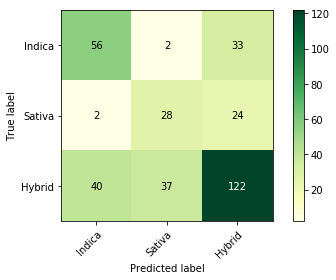

In [251]:
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])

## Getting best KNN model

In [252]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 19
Accuracy: 0.6686046511627907


In [253]:
clf1 = KNeighborsClassifier(n_neighbors=19)
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.6 0.7 0.7]
Recall Score: [0.6 0.4 0.8]
Accuracy Score: 0.6686046511627907
F1 Score: [0.6 0.5 0.7]
              precision    recall  f1-score   support

      indica       0.61      0.62      0.61        91
      satica       0.67      0.41      0.51        54
      hybrid       0.69      0.76      0.73       199

   micro avg       0.67      0.67      0.67       344
   macro avg       0.66      0.60      0.62       344
weighted avg       0.67      0.67      0.66       344



Predicted   0   1    2  All
True                       
0          56   0   35   91
1           0  22   32   54
2          36  11  152  199
All        92  33  219  344


<Figure size 720x360 with 0 Axes>

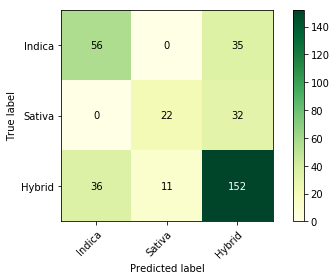

In [255]:
plt.figure(figsize=(10,5))
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])
plt.savefig('BestKKNNConfuseMatrix.png', bbox_inches='tight')

### With Selected Features:

In [33]:
find_best_k(df_train, y_train, df_test, y_test)

Best Value for k: 17
Accuracy: 0.6627906976744186


In [34]:
clf1 = KNeighborsClassifier(n_neighbors=17)
clf1.fit(df_train, y_train)
test_preds = clf1.predict(df_test)
print_metrics(y_test, test_preds)
dt_cv_score=cross_val_score(clf1, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.6 0.5 0.7]
Recall Score: [0.6 0.6 0.7]
Accuracy Score: 0.6627906976744186
F1 Score: [0.6 0.6 0.7]
Mean Cross Validation Score: 60.97%
              precision    recall  f1-score   support

      indica       0.62      0.63      0.62        91
      satica       0.53      0.65      0.58        54
      hybrid       0.73      0.68      0.71       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.63      0.65      0.64       344
weighted avg       0.67      0.66      0.67       344



Predicted   0   1    2  All
True                       
0          57   1   33   91
1           2  35   17   54
2          33  30  136  199
All        92  66  186  344


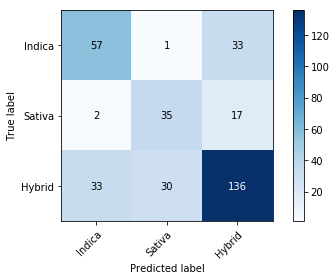

In [35]:
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])

### With PCA

In [36]:
find_best_k(Xptrain, yptrain, Xptest, yptest)

Best Value for k: 19
Accuracy: 0.5319767441860465


In [37]:
clf1 = KNeighborsClassifier(n_neighbors=19)
clf1.fit(Xptrain, yptrain)
test_preds = clf1.predict(Xptest)
print_metrics(yptest, test_preds)
dt_cv_score=cross_val_score(clf1, Xptrain, yptrain)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
print(classification_report(yptest,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.3 0.2 0.6]
Recall Score: [0.1 0.1 0.8]
Accuracy Score: 0.5319767441860465
F1 Score: [0.2 0.1 0.7]
Mean Cross Validation Score: 45.82%
              precision    recall  f1-score   support

      indica       0.29      0.13      0.18        91
      satica       0.25      0.06      0.09        54
      hybrid       0.58      0.84      0.69       199

   micro avg       0.53      0.53      0.53       344
   macro avg       0.37      0.34      0.32       344
weighted avg       0.45      0.53      0.46       344



Predicted   0   1    2  All
True                       
0          12   2   77   91
1           6   3   45   54
2          24   7  168  199
All        42  12  290  344


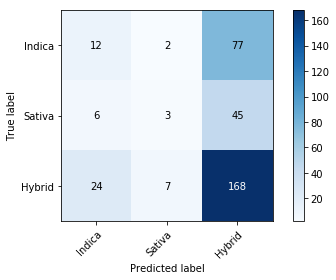

In [38]:
plot_corr_matrix(yptest,test_preds,['Indica','Sativa','Hybrid'])

In [38]:
model=KNeighborsClassifier()

### Grid Search with KNN: All Features

In [39]:
dt_cv_score=cross_val_score(model, scaled_data_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'n_neighbors':list(range(1,31)),
    'weights':['uniform','distance']
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(scaled_data_train, y_train)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_data_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_


Mean Cross Validation Score: 55.54%
Mean Training Score: 83.82%
Mean Testing Score: 65.99%
Best Parameter Combination Found During Grid Search:


{'n_neighbors': 26, 'weights': 'uniform'}

In [40]:
clf1 = KNeighborsClassifier(n_neighbors=26, weights='uniform')
clf1.fit(scaled_data_train, y_train)
test_preds = clf1.predict(scaled_data_test)
print_metrics(y_test, test_preds)
dt_cv_score=cross_val_score(clf1, scaled_data_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.6 0.6 0.7]
Recall Score: [0.6 0.4 0.7]
Accuracy Score: 0.6598837209302325
F1 Score: [0.6 0.5 0.7]
Mean Cross Validation Score: 61.36%
              precision    recall  f1-score   support

      indica       0.60      0.63      0.61        91
      satica       0.62      0.44      0.52        54
      hybrid       0.70      0.73      0.71       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.64      0.60      0.61       344
weighted avg       0.66      0.66      0.66       344



Predicted   0   1    2  All
True                       
0          57   0   34   91
1           0  24   30   54
2          38  15  146  199
All        95  39  210  344


<Figure size 720x360 with 0 Axes>

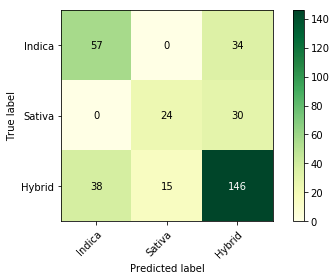

In [42]:
plt.figure(figsize=(10,5))
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])
plt.savefig('GridKNNConfuseMatrix.png', bbox_inches='tight')

#### KNN Grid Search Selected Features

In [43]:
dt_cv_score=cross_val_score(model, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'n_neighbors':list(range(1,31)),
    'weights':['uniform','distance']
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(df_train, y_train)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Cross Validation Score: 55.83%
Mean Training Score: 82.72%
Mean Testing Score: 66.28%
Best Parameter Combination Found During Grid Search:


{'n_neighbors': 26, 'weights': 'uniform'}

In [44]:
clf1 = KNeighborsClassifier(n_neighbors=26)
clf1.fit(df_train, y_train)
test_preds = clf1.predict(df_test)
print_metrics(y_test, test_preds)
dt_cv_score=cross_val_score(clf1, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
print(classification_report(y_test,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.6 0.5 0.7]
Recall Score: [0.6 0.5 0.7]
Accuracy Score: 0.6627906976744186
F1 Score: [0.6 0.5 0.7]
Mean Cross Validation Score: 62.53%
              precision    recall  f1-score   support

      indica       0.63      0.60      0.62        91
      satica       0.53      0.50      0.51        54
      hybrid       0.71      0.73      0.72       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.62      0.61      0.62       344
weighted avg       0.66      0.66      0.66       344



Predicted   0   1    2  All
True                       
0          55   1   35   91
1           2  27   25   54
2          30  23  146  199
All        87  51  206  344


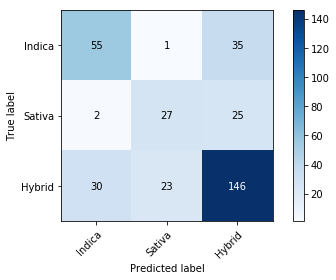

In [45]:
plot_corr_matrix(y_test,test_preds,['Indica','Sativa','Hybrid'])

### KNN Grid Search PCA

In [46]:
dt_cv_score=cross_val_score(model, Xptrain, yptrain)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'n_neighbors':list(range(1,31)),
    'weights':['uniform','distance']
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(Xptrain, yptrain)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(Xptest, yptest)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Cross Validation Score: 44.18%
Mean Training Score: 78.8%
Mean Testing Score: 50.87%
Best Parameter Combination Found During Grid Search:


{'n_neighbors': 10, 'weights': 'uniform'}

In [47]:
clf1 = KNeighborsClassifier(n_neighbors=10)
clf1.fit(Xptrain, yptrain)
test_preds = clf1.predict(Xptest)
print_metrics(yptest, test_preds)
dt_cv_score=cross_val_score(clf1, Xptrain, yptrain)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
print(classification_report(yptest,test_preds,target_names=['indica','satica','hybrid']))

Precision Score: [0.4 0.2 0.6]
Recall Score: [0.3 0.1 0.7]
Accuracy Score: 0.5087209302325582
F1 Score: [0.4 0.1 0.6]
Mean Cross Validation Score: 45.44%
              precision    recall  f1-score   support

      indica       0.39      0.34      0.36        91
      satica       0.17      0.11      0.13        54
      hybrid       0.61      0.69      0.65       199

   micro avg       0.51      0.51      0.51       344
   macro avg       0.39      0.38      0.38       344
weighted avg       0.48      0.51      0.49       344



Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


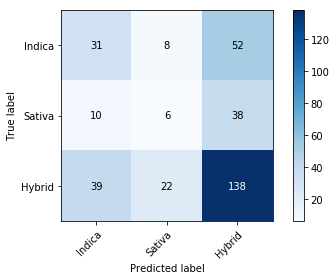

In [48]:
plot_corr_matrix(yptest,test_preds,['Indica','Sativa','Hybrid'])

## Decision Tree

### Baseline Decision Tree

In [126]:
# !pip install dtreeplt

In [141]:
classifier1 = DecisionTreeClassifier()  
classifier1.fit(scaled_data_train, y_train) 
y_pred = classifier1.predict(scaled_data_test)

In [142]:
# tree.export_graphviz(classifier1) 
# from dtreeplt import dtreeplt
# plt.figure(figsize=(20,20))
# dtree = dtreeplt(
#     model=classifier1,
#     feature_names=features.columns,
#     target_names=fulldf['type']
# )
# fig = dtree.view()
# fig.savefig('DT1.png')

In [143]:
y_score = classifier1.score(scaled_data_test, y_test)
print('Accuracy: ', y_score)

# Compute the average precision score
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier1,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)

Accuracy:  0.5377906976744186
Micro-averaged precision score: 0.54
Macro-averaged precision score: 0.56
Per-class precision score: [0.6 0.6 0.5]
Precision Score: [0.5 0.4 0.7]
Recall Score: [0.6 0.6 0.5]
Accuracy Score: 0.5377906976744186
F1 Score: [0.5 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.49      0.60      0.54        91
      satica       0.39      0.59      0.47        54
      hybrid       0.65      0.49      0.56       199

   micro avg       0.54      0.54      0.54       344
   macro avg       0.51      0.56      0.52       344
weighted avg       0.57      0.54      0.54       344



Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


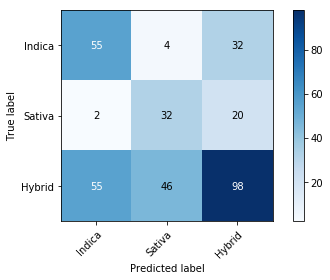

In [144]:
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With Selected Features:

In [138]:
classifier1 = DecisionTreeClassifier()  
classifier1.fit(df_train, y_train) 
y_pred = classifier1.predict(df_test)

Accuracy:  0.5261627906976745
Micro-averaged precision score: 0.53
Macro-averaged precision score: 0.57
Per-class precision score: [0.5 0.7 0.5]
Precision Score: [0.5 0.4 0.6]
Recall Score: [0.5 0.7 0.5]
Accuracy Score: 0.5261627906976745
F1 Score: [0.5 0.5 0.5]
              precision    recall  f1-score   support

      indica       0.48      0.54      0.51        91
      satica       0.40      0.69      0.51        54
      hybrid       0.64      0.48      0.55       199

   micro avg       0.53      0.53      0.53       344
   macro avg       0.51      0.57      0.52       344
weighted avg       0.56      0.53      0.53       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


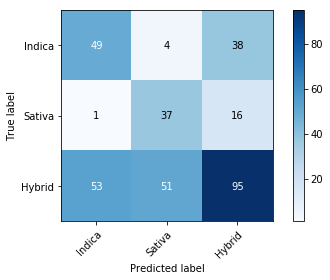

In [139]:
y_score = classifier1.score(df_test, y_test)
print('Accuracy: ', y_score)

# Compute the average precision score
micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier1,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With PCA

In [145]:
classifier1.fit(Xptrain, yptrain) 
y_pred = classifier1.predict(Xptest)

Accuracy:  0.47093023255813954
Micro-averaged precision score: 0.47
Macro-averaged precision score: 0.41
Per-class precision score: [0.4 0.3 0.6]
Precision Score: [0.4 0.2 0.6]
Recall Score: [0.4 0.3 0.6]
Accuracy Score: 0.47093023255813954
F1 Score: [0.4 0.2 0.6]
              precision    recall  f1-score   support

      indica       0.35      0.36      0.36        91
      satica       0.21      0.30      0.24        54
      hybrid       0.65      0.57      0.61       199

   micro avg       0.47      0.47      0.47       344
   macro avg       0.40      0.41      0.40       344
weighted avg       0.50      0.47      0.48       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


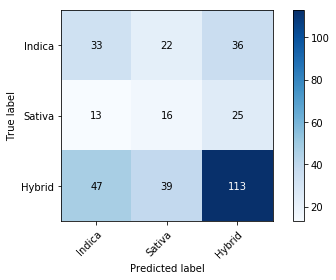

In [146]:
y_score = classifier1.score(Xptest, yptest)
print('Accuracy: ', y_score)

# Compute the average precision score
micro_precision = precision_score(y_pred, yptest, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, yptest, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, yptest, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(yptest,y_pred)
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier1,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(yptest,y_pred,['Indica','Sativa','Hybrid'])

## Decision Tree with random state=10

In [147]:
classifier2 = DecisionTreeClassifier(random_state=10)  
classifier2.fit(scaled_data_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [148]:
y_pred = classifier2.predict(scaled_data_test)

Accuracy:  0.5377906976744186
Micro-averaged precision score: 0.54
Macro-averaged precision score: 0.56
Per-class precision score: [0.6 0.6 0.5]
Precision Score: [0.5 0.4 0.7]
Recall Score: [0.6 0.6 0.5]
Accuracy Score: 0.5377906976744186
F1 Score: [0.5 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.48      0.58      0.52        91
      satica       0.40      0.61      0.49        54
      hybrid       0.66      0.50      0.57       199

   micro avg       0.54      0.54      0.54       344
   macro avg       0.51      0.56      0.53       344
weighted avg       0.57      0.54      0.54       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


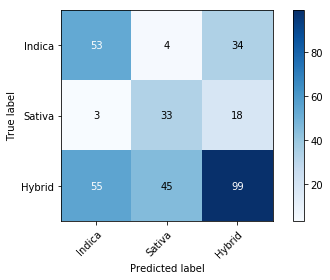

In [149]:
y_score = classifier2.score(scaled_data_test, y_test)
print('Accuracy: ', y_score)

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier2,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With Selected Features:

In [150]:
classifier2 = DecisionTreeClassifier(random_state=10)  
classifier2.fit(df_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy:  0.5436046511627907
Micro-averaged precision score: 0.54
Macro-averaged precision score: 0.57
Per-class precision score: [0.5 0.7 0.5]
Precision Score: [0.5 0.4 0.6]
Recall Score: [0.5 0.7 0.5]
Accuracy Score: 0.5436046511627907
F1 Score: [0.5 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.52      0.54      0.53        91
      satica       0.39      0.67      0.49        54
      hybrid       0.65      0.51      0.57       199

   micro avg       0.54      0.54      0.54       344
   macro avg       0.52      0.57      0.53       344
weighted avg       0.57      0.54      0.55       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


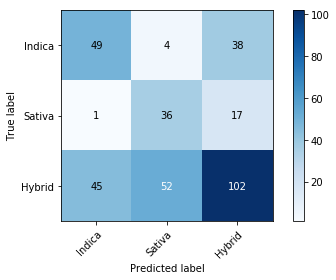

In [152]:
y_pred = classifier2.predict(df_test)
y_score = classifier2.score(df_test, y_test)
print('Accuracy: ', y_score)

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)

print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier2,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With PCA

Accuracy:  0.4680232558139535
Micro-averaged precision score: 0.47
Macro-averaged precision score: 0.41
Per-class precision score: [0.4 0.3 0.5]
Precision Score: [0.4 0.2 0.6]
Recall Score: [0.4 0.3 0.5]
Accuracy Score: 0.4680232558139535
F1 Score: [0.4 0.3 0.6]
              precision    recall  f1-score   support

      indica       0.36      0.40      0.37        91
      satica       0.22      0.30      0.25        54
      hybrid       0.64      0.55      0.59       199

   micro avg       0.47      0.47      0.47       344
   macro avg       0.41      0.41      0.41       344
weighted avg       0.50      0.47      0.48       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


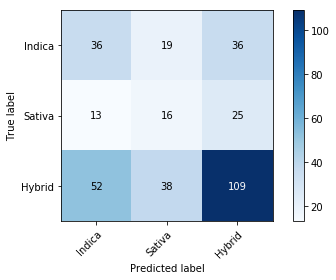

In [154]:
classifier2.fit(Xptrain, yptrain) 
y_pred = classifier2.predict(Xptest)
y_score = classifier2.score(Xptest, yptest)
print('Accuracy: ', y_score)

micro_precision = precision_score(y_pred, yptest, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, yptest, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, yptest, average=None)
print('Per-class precision score:', per_class_precision)

print_metrics(y_test,y_pred)
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier2,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

## Decision Tree using entropy and random state=10

In [155]:
classifier3 = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier3.fit(scaled_data_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy is: 0.5755813953488372
Micro-averaged precision score: 0.58
Macro-averaged precision score: 0.61
Per-class precision score: [0.6 0.7 0.5]
Precision Score: [0.5 0.4 0.7]
Recall Score: [0.6 0.7 0.5]
Accuracy Score: 0.5755813953488372
F1 Score: [0.6 0.5 0.6]
              precision    recall  f1-score   support

      indica       0.52      0.64      0.57        91
      satica       0.43      0.67      0.52        54
      hybrid       0.70      0.52      0.60       199

   micro avg       0.58      0.58      0.58       344
   macro avg       0.55      0.61      0.56       344
weighted avg       0.61      0.58      0.58       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


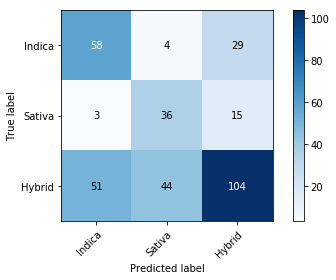

In [157]:
y_pred = classifier3.predict(scaled_data_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With Selected Features:

In [158]:
classifier3 = DecisionTreeClassifier(criterion='entropy',random_state=10)  
classifier3.fit(df_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

Accuracy is: 0.5261627906976745
Micro-averaged precision score: 0.53
Macro-averaged precision score: 0.57
Per-class precision score: [0.6 0.7 0.5]
Precision Score: [0.5 0.3 0.7]
Recall Score: [0.6 0.7 0.5]
Accuracy Score: 0.5261627906976745
F1 Score: [0.6 0.5 0.5]
              precision    recall  f1-score   support

      indica       0.53      0.59      0.56        91
      satica       0.35      0.67      0.46        54
      hybrid       0.65      0.46      0.54       199

   micro avg       0.53      0.53      0.53       344
   macro avg       0.51      0.57      0.52       344
weighted avg       0.57      0.53      0.53       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


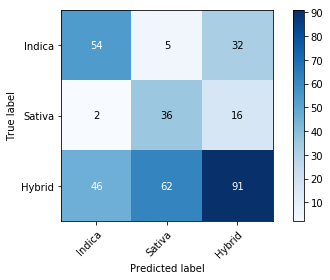

In [159]:
y_pred = classifier3.predict(df_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With PCA

Accuracy is: 0.4738372093023256
Micro-averaged precision score: 0.47
Macro-averaged precision score: 0.41
Per-class precision score: [0.4 0.2 0.6]
Precision Score: [0.4 0.2 0.6]
Recall Score: [0.4 0.2 0.6]
Accuracy Score: 0.4738372093023256
F1 Score: [0.4 0.2 0.6]
              precision    recall  f1-score   support

      indica       0.37      0.42      0.39        91
      satica       0.19      0.24      0.21        54
      hybrid       0.64      0.56      0.60       199

   micro avg       0.47      0.47      0.47       344
   macro avg       0.40      0.41      0.40       344
weighted avg       0.50      0.47      0.48       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


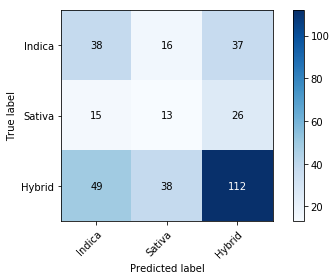

In [161]:
classifier3.fit(Xptrain, yptrain) 
y_pred = classifier3.predict(Xptest)

acc = accuracy_score(yptest,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, yptest, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, yptest, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, yptest, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(yptest,y_pred)
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(yptest,y_pred,['Indica','Sativa','Hybrid'])

In [68]:
#Still need to get F1, Recall, and Decision Tree visualization!!!

## Grid Search with Decision Tree: All Features

In [43]:
model=DecisionTreeClassifier()
dt_cv_score=cross_val_score(model, scaled_data_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]   
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(scaled_data_train, y_train)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_data_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Cross Validation Score: 51.17%
Mean Training Score: 68.29%
Mean Testing Score: 65.7%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [44]:
classifier3 = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_leaf=4,min_samples_split=2)  
classifier3.fit(scaled_data_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy is: 0.6569767441860465
Micro-averaged precision score: 0.66
Macro-averaged precision score: 0.61
Per-class precision score: [0.6 0.6 0.7]
Precision Score: [0.7 0.5 0.7]
Recall Score: [0.6 0.6 0.7]
Accuracy Score: 0.6569767441860465
F1 Score: [0.6 0.5 0.7]
              precision    recall  f1-score   support

      indica       0.73      0.56      0.63        91
      satica       0.46      0.56      0.50        54
      hybrid       0.69      0.73      0.71       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.63      0.61      0.62       344
weighted avg       0.67      0.66      0.66       344

Predicted   0   1    2  All
True                       
0          51   0   40   91
1           0  30   24   54
2          19  35  145  199
All        70  65  209  344


<Figure size 720x360 with 0 Axes>

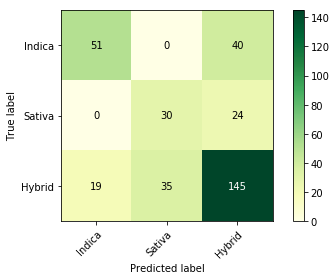

In [45]:
y_pred = classifier3.predict(scaled_data_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)
plt.figure(figsize=(10,5))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('DecisionTreeGridSearch.png')


### Grid Search Decision Tree: Selected Features

In [165]:
model=DecisionTreeClassifier()
dt_cv_score=cross_val_score(model, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]   
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(df_train, y_train)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Cross Validation Score: 52.14%
Mean Training Score: 67.08%
Mean Testing Score: 65.99%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [166]:
classifier3 = DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_leaf=3,min_samples_split=2)  
classifier3.fit(df_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy is: 0.6598837209302325
Micro-averaged precision score: 0.66
Macro-averaged precision score: 0.62
Per-class precision score: [0.6 0.6 0.7]
Precision Score: [0.7 0.5 0.7]
Recall Score: [0.6 0.6 0.7]
Accuracy Score: 0.6598837209302325
F1 Score: [0.6 0.5 0.7]
              precision    recall  f1-score   support

      indica       0.74      0.56      0.64        91
      satica       0.46      0.56      0.50        54
      hybrid       0.70      0.73      0.71       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.63      0.62      0.62       344
weighted avg       0.67      0.66      0.66       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


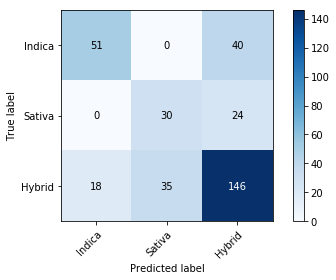

In [168]:
y_pred = classifier3.predict(df_test)
acc = accuracy_score(y_test,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, y_test, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, y_test, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

### With PCA

In [169]:
model=DecisionTreeClassifier()
dt_cv_score=cross_val_score(model, Xptrain, yptrain)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

dt_param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]   
}

dt_grid_search = GridSearchCV(model, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(Xptrain, yptrain)

dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(Xptest, yptest)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Cross Validation Score: 45.53%
Mean Training Score: 58.01%
Mean Testing Score: 54.36%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [170]:
classifier3 = DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1,min_samples_split=5)  
classifier3.fit(Xptrain, yptrain) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy is: 0.5436046511627907
Micro-averaged precision score: 0.54
Macro-averaged precision score: 0.35
Per-class precision score: [0.2 0.  0.9]
Precision Score: [0.3 0.3 0.6]
Recall Score: [0.2 0.  0.9]
Accuracy Score: 0.5436046511627907
F1 Score: [0.2 0.  0.7]
              precision    recall  f1-score   support

      indica       0.31      0.15      0.21        91
      satica       0.33      0.02      0.04        54
      hybrid       0.58      0.86      0.69       199

   micro avg       0.54      0.54      0.54       344
   macro avg       0.41      0.35      0.31       344
weighted avg       0.47      0.54      0.46       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


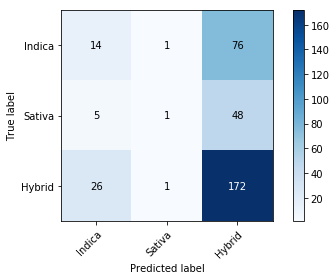

In [171]:
y_pred = classifier3.predict(Xptest)
acc = accuracy_score(yptest,y_pred)
print("Accuracy is: {}".format(acc))

micro_precision = precision_score(y_pred, yptest, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(
      micro_precision))

macro_precision = precision_score(y_pred, yptest, average='macro')
print('Macro-averaged precision score: {0:0.2f}'.format(
      macro_precision))

per_class_precision = precision_score(y_pred, yptest, average=None)
print('Per-class precision score:', per_class_precision)
print_metrics(yptest,y_pred)
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))
# roc(classifier3,df_train,df_test,y_train,y_test,n_classes)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

## Random Forest

### Regular Forest Baseline

Precision Score: [0.5 0.5 0.8]
Recall Score: [0.8 0.6 0.7]
Accuracy Score: 0.688953488372093
F1 Score: [0.6 0.5 0.8]
              precision    recall  f1-score   support

      indica       0.75      0.46      0.57        91
      satica       0.60      0.50      0.55        54
      hybrid       0.69      0.84      0.76       199

   micro avg       0.69      0.69      0.69       344
   macro avg       0.68      0.60      0.63       344
weighted avg       0.69      0.69      0.68       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


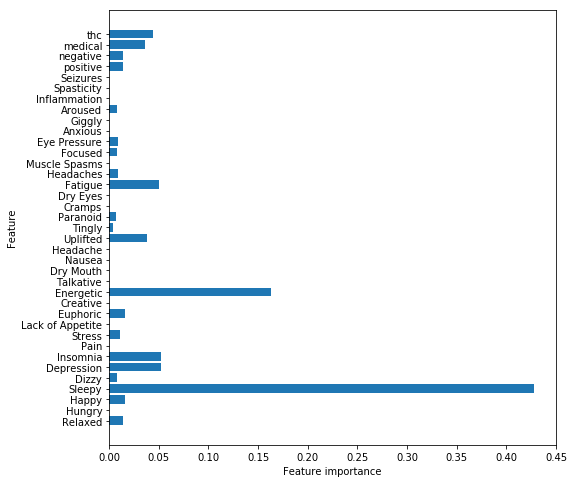

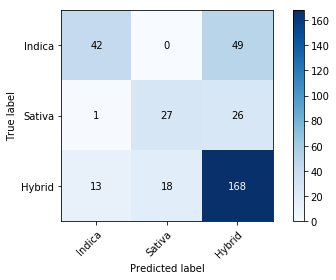

In [178]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(scaled_data_train, y_train)
y_pred=tree_clf.predict(scaled_data_test)
# roc(tree_clf,scaled_data_train,scaled_data_test,y_train,y_test,n_classes)
plot_feature_importances(tree_clf, pd.DataFrame(X_train))
print_metrics(y_pred,y_test)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

#### With Selected Feautres:

Precision Score: [0.6 0.5 0.8]
Recall Score: [0.7 0.6 0.7]
Accuracy Score: 0.6802325581395349
F1 Score: [0.6 0.5 0.7]
              precision    recall  f1-score   support

      indica       0.65      0.58      0.62        91
      satica       0.59      0.50      0.54        54
      hybrid       0.71      0.77      0.74       199

   micro avg       0.68      0.68      0.68       344
   macro avg       0.65      0.62      0.63       344
weighted avg       0.68      0.68      0.68       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


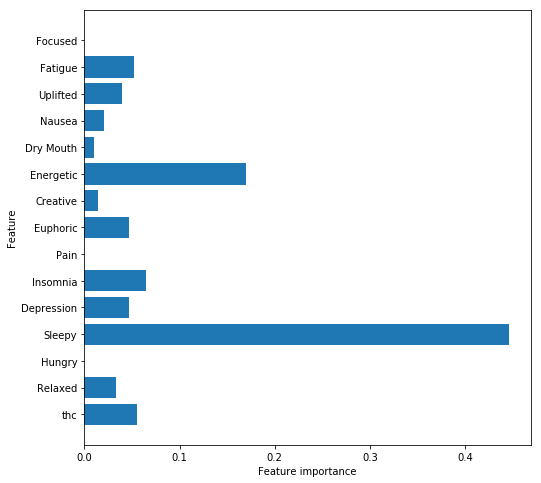

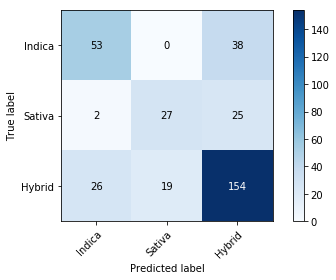

In [181]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(df_train, y_train)
y_preds=tree_clf.predict(df_test)
# roc(tree_clf,df_train,df_test,y_train,y_test,n_classes)
plot_feature_importances(tree_clf, df_train)
print_metrics(y_preds,y_test)
print(classification_report(y_test,y_preds,target_names=['indica','satica','hybrid']))
plot_corr_matrix(y_test,y_preds,['Indica','Sativa','Hybrid'])

### With PCA

Precision Score: [0.1 0.  0.9]
Recall Score: [0.4 0.  0.6]
Accuracy Score: 0.5697674418604651
F1 Score: [0.2 0.  0.7]
              precision    recall  f1-score   support

      indica       0.38      0.11      0.17        91
      satica       0.00      0.00      0.00        54
      hybrid       0.58      0.93      0.72       199

   micro avg       0.57      0.57      0.57       344
   macro avg       0.32      0.35      0.30       344
weighted avg       0.44      0.57      0.46       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


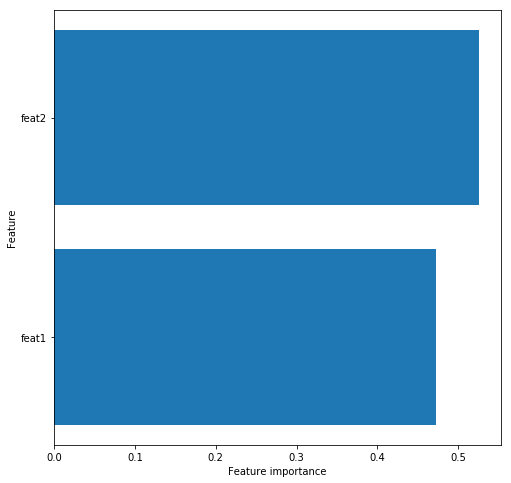

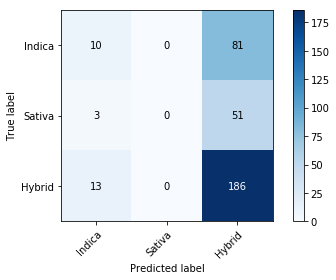

In [182]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(Xptrain, yptrain)
y_preds=tree_clf.predict(Xptest)
# roc(tree_clf,df_train,df_test,y_train,y_test,n_classes)
plot_feature_importances(tree_clf, Xptrain)
print_metrics(y_preds,yptest)
print(classification_report(yptest,y_preds,target_names=['indica','satica','hybrid']))
plot_corr_matrix(y_test,y_preds,['Indica','Sativa','Hybrid'])

In [183]:
#How to with multilabel-indicator????
# pred = tree_clf.predict(X_test)
# print(confusion_matrix(y_test, pred))
# print(classification_report(X_test, pred))

# acc = accuracy_score(y_test,y_pred)
# print("Accuracy is: {}".format(acc))

### Forest

In [47]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(scaled_data_train, y_train)
y_pred=forest.predict(scaled_data_test)

Training Score: 0.6941747572815534
Testing Score: 0.6831395348837209
Precision Score: [0.6 0.3 0.8]
Recall Score: [0.7 0.6 0.7]
Accuracy Score: 0.6831395348837209
F1 Score: [0.6 0.4 0.8]
              precision    recall  f1-score   support

      indica       0.73      0.57      0.64        91
      satica       0.56      0.28      0.37        54
      hybrid       0.68      0.84      0.76       199

   micro avg       0.68      0.68      0.68       344
   macro avg       0.66      0.56      0.59       344
weighted avg       0.68      0.68      0.66       344

Predicted   0   1    2  All
True                       
0          52   0   39   91
1           0  15   39   54
2          19  12  168  199
All        71  27  246  344


<Figure size 720x360 with 0 Axes>

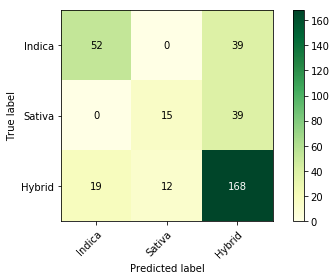

In [50]:
train_score=forest.score(scaled_data_train,y_train)
test_score=forest.score(scaled_data_test,y_test)
print('Training Score: {}'.format(train_score))
print('Testing Score: {}'.format(test_score))
print_metrics(y_pred,y_test)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plt.figure(figsize=(10,5))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('ForrestAllDataMtx.png')

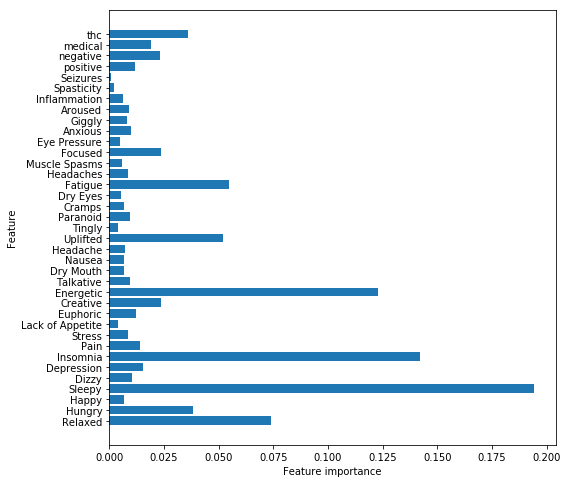

In [187]:
plot_feature_importances(forest,pd.DataFrame(X_train))

### For Selected Features:

In [52]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(df_train, y_train)
y_pred=forest.predict(df_test)

Training Score: 0.6825242718446602
Testing Score: 0.6656976744186046
              precision    recall  f1-score   support

      indica       0.68      0.57      0.62        91
      satica       0.52      0.41      0.46        54
      hybrid       0.69      0.78      0.73       199

   micro avg       0.67      0.67      0.67       344
   macro avg       0.63      0.59      0.60       344
weighted avg       0.66      0.67      0.66       344

Precision Score: [0.6 0.4 0.8]
Recall Score: [0.7 0.5 0.7]
Accuracy Score: 0.6656976744186046
F1 Score: [0.6 0.5 0.7]
Predicted   0   1    2  All
True                       
0          52   0   39   91
1           0  22   32   54
2          24  20  155  199
All        76  42  226  344


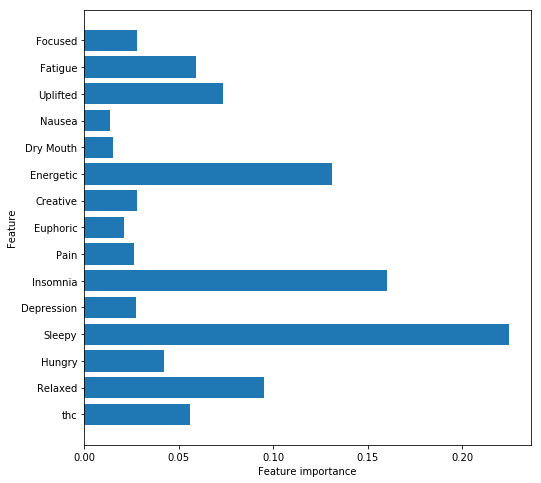

<Figure size 720x432 with 0 Axes>

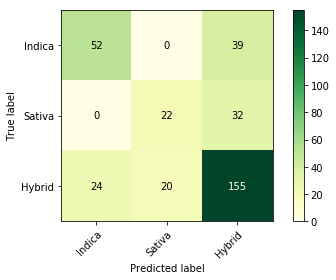

In [53]:
train_score=forest.score(df_train,y_train)
test_score=forest.score(df_test,y_test)
print('Training Score: {}'.format(train_score))
print('Testing Score: {}'.format(test_score))
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
print_metrics(y_pred,y_test)
plot_feature_importances(forest,pd.DataFrame(df_train))
plt.figure(figsize=(10,6))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('SelectedForestMtx.png')

### With PCA

In [193]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(Xptrain, yptrain)
y_pred=forest.predict(Xptest)

Training Score: 0.5640776699029126
Testing Score: 0.561046511627907
              precision    recall  f1-score   support

      indica       0.35      0.14      0.20        91
      sativa       0.00      0.00      0.00        54
      hybrid       0.59      0.90      0.71       199

   micro avg       0.56      0.56      0.56       344
   macro avg       0.31      0.35      0.30       344
weighted avg       0.43      0.56      0.47       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


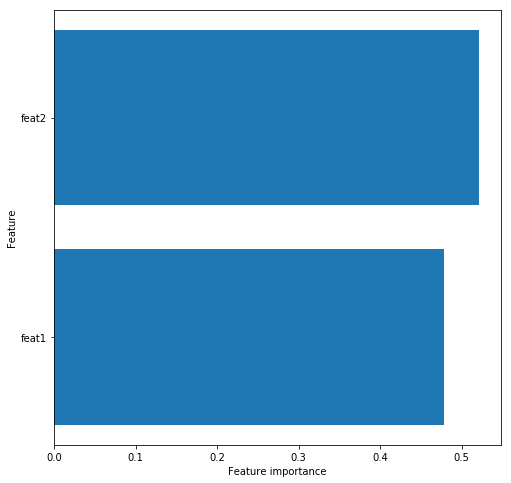

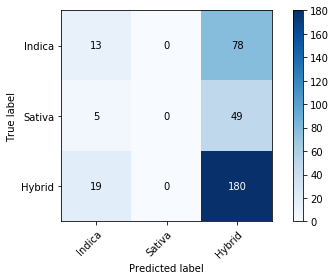

In [195]:
train_score=forest.score(Xptrain,yptrain)
test_score=forest.score(Xptest,yptest)
print('Training Score: {}'.format(train_score))
print('Testing Score: {}'.format(test_score))
print(classification_report(yptest,y_pred,target_names=['indica','sativa','hybrid']))
plot_feature_importances(forest,pd.DataFrame(Xptrain))
plot_corr_matrix(yptest,y_pred,['Indica','Sativa','Hybrid'])

## Forest with n_Est=5, max_feat=10, and max_depth=2

In [54]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(scaled_data_train, y_train)
y_pred=forest_2.predict(scaled_data_test)

Training Score:  0.6242718446601941
Testing Score:  0.6744186046511628
              precision    recall  f1-score   support

      indica       0.70      0.54      0.61        91
      satica       0.59      0.30      0.40        54
      hybrid       0.68      0.84      0.75       199

   micro avg       0.67      0.67      0.67       344
   macro avg       0.66      0.56      0.58       344
weighted avg       0.67      0.67      0.66       344

Predicted   0   1    2  All
True                       
0          49   0   42   91
1           0  16   38   54
2          21  11  167  199
All        70  27  247  344
Precision Score: [0.5 0.3 0.8]
Recall Score: [0.7 0.6 0.7]
Accuracy Score: 0.6744186046511628
F1 Score: [0.6 0.4 0.7]


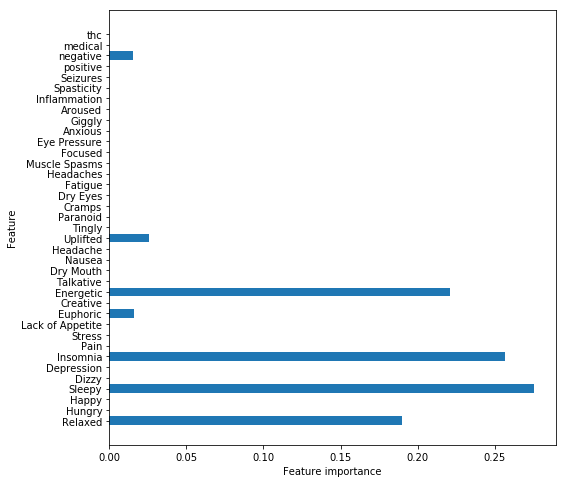

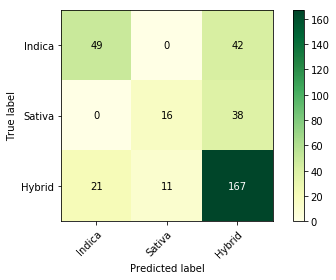

In [55]:
print("Training Score: ",forest_2.score(scaled_data_train,y_train))
print("Testing Score: ",forest_2.score(scaled_data_test,y_test))
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_feature_importances(forest_2,pd.DataFrame(X_train))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
print_metrics(y_pred,y_test)

### With Selected Features:

In [56]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(df_train, y_train)
y_pred=forest_2.predict(df_test)

Training Score:  0.6300970873786408
Testing Score:  0.6569767441860465
              precision    recall  f1-score   support

      indica       0.69      0.54      0.60        91
      satica       0.50      0.39      0.44        54
      hybrid       0.68      0.78      0.73       199

   micro avg       0.66      0.66      0.66       344
   macro avg       0.62      0.57      0.59       344
weighted avg       0.65      0.66      0.65       344

Predicted   0   1    2  All
True                       
0          49   0   42   91
1           0  21   33   54
2          22  21  156  199
All        71  42  231  344
Precision Score: [0.5 0.4 0.8]
Recall Score: [0.7 0.5 0.7]
Accuracy Score: 0.6569767441860465
F1 Score: [0.6 0.4 0.7]


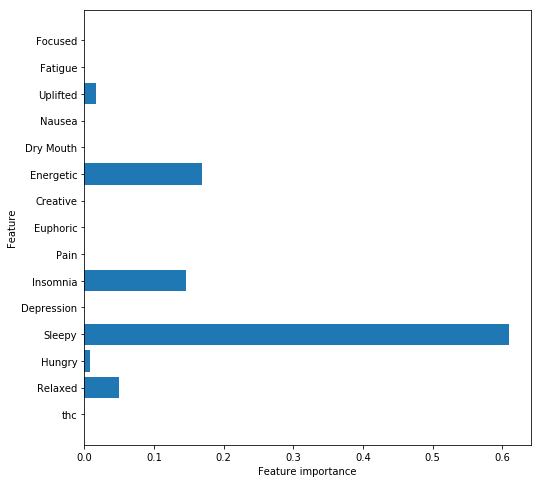

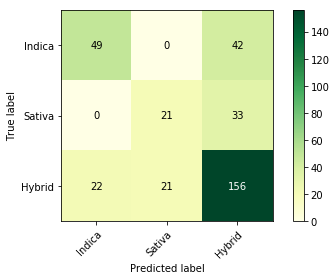

In [57]:
print("Training Score: ",forest_2.score(df_train,y_train))
print("Testing Score: ",forest_2.score(df_test,y_test))
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_feature_importances(forest_2,pd.DataFrame(df_train))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
print_metrics(y_pred,y_test)

## Grid Search Forest All Data

In [58]:
dt_clf=RandomForestClassifier()
dt_cv_score=cross_val_score(dt_clf, scaled_data_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))

Mean Cross Validation Score: 57.49%


In [59]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators':[1,2,3,4,5,6,7,8,9],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [205]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(scaled_data_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [206]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(scaled_data_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 66.01%
Mean Testing Score: 64.53%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 8}

In [60]:
forest3 = RandomForestClassifier(criterion='gini', max_depth=None,min_samples_leaf=4,min_samples_split=5,n_estimators=9)
forest3.fit(scaled_data_train, y_train)
y_pred=forest3.predict(scaled_data_test)

Precision Score: [0.6 0.5 0.7]
Recall Score: [0.5 0.4 0.8]
Accuracy Score: 0.6453488372093024
F1 Score: [0.6 0.4 0.7]
              precision    recall  f1-score   support

      indica       0.64      0.55      0.59        91
      satica       0.49      0.39      0.43        54
      hybrid       0.68      0.76      0.72       199

   micro avg       0.65      0.65      0.65       344
   macro avg       0.60      0.57      0.58       344
weighted avg       0.64      0.65      0.64       344

Predicted   0   1    2  All
True                       
0          50   1   40   91
1           1  21   32   54
2          27  21  151  199
All        78  43  223  344


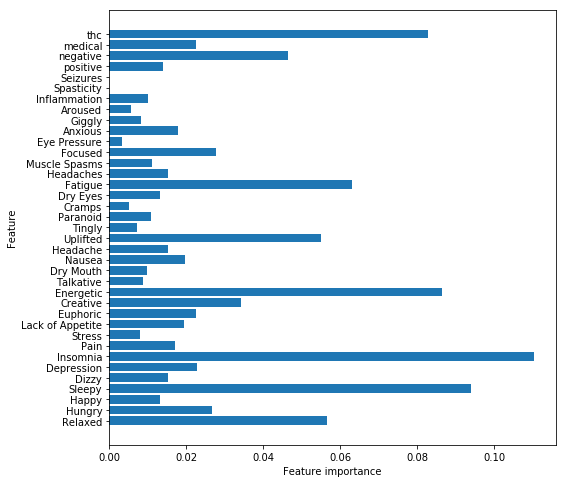

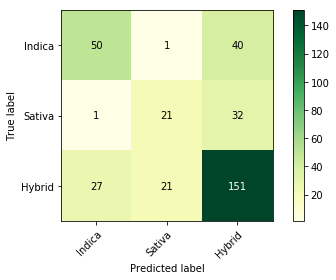

In [61]:
y_pred=forest3.predict(scaled_data_test)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_feature_importances(forest3,pd.DataFrame(X_train))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

In [209]:
print("Training Score: ",forest3.score(scaled_data_train,y_train))
print("Testing Score: ",forest3.score(scaled_data_test,y_test))

Training Score:  0.7466019417475728
Testing Score:  0.6569767441860465


#### Grid Search Forest Selected

In [210]:
dt_clf=RandomForestClassifier()
dt_cv_score=cross_val_score(dt_clf, df_train, y_train)
meandtcv=dt_cv_score.mean()
print("Mean Cross Validation Score: {:.4}%".format(meandtcv * 100))
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=10, return_train_score=True)
dt_grid_search.fit(df_train, y_train)

Mean Cross Validation Score: 55.35%


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [211]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(df_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 65.37%
Mean Testing Score: 65.41%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 7}

In [212]:
forest3 = RandomForestClassifier(criterion='entropy', max_depth=4,min_samples_leaf=3,min_samples_split=2,n_estimators=5)
forest3.fit(scaled_data_train, y_train)
y_pred=forest3.predict(scaled_data_test)

Precision Score: [0.6 0.5 0.7]
Recall Score: [0.5 0.4 0.8]
Accuracy Score: 0.6453488372093024
F1 Score: [0.6 0.4 0.7]
              precision    recall  f1-score   support

      indica       0.64      0.55      0.59        91
      satica       0.49      0.39      0.43        54
      hybrid       0.68      0.76      0.72       199

   micro avg       0.65      0.65      0.65       344
   macro avg       0.60      0.57      0.58       344
weighted avg       0.64      0.65      0.64       344

Predicted   0   1    2  All
True                       
0          50   1   40   91
1           1  21   32   54
2          27  21  151  199
All        78  43  223  344


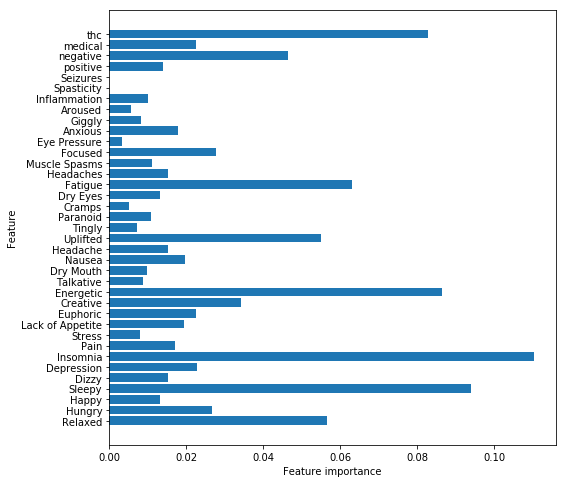

<Figure size 720x360 with 0 Axes>

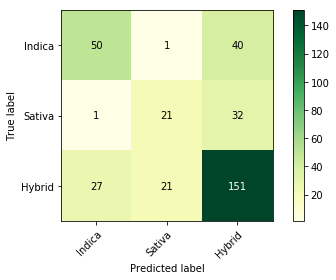

In [62]:
y_pred=forest3.predict(scaled_data_test)
print_metrics(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_feature_importances(forest3,pd.DataFrame(X_train))
plt.figure(figsize=(10,5))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('SelectedForestGridSearch')

In [216]:
print("Training Score: ",forest3.score(scaled_data_train,y_train))
print("Testing Score: ",forest3.score(scaled_data_test,y_test))

Training Score:  0.6466019417475728
Testing Score:  0.686046511627907


## SVM

              precision    recall  f1-score   support

      indica       0.68      0.59      0.63        91
      satica       0.64      0.52      0.57        54
      hybrid       0.71      0.79      0.75       199

   micro avg       0.69      0.69      0.69       344
   macro avg       0.68      0.63      0.65       344
weighted avg       0.69      0.69      0.69       344

Predicted   0   1    2  All
True                       
0          54   0   37   91
1           0  28   26   54
2          26  16  157  199
All        80  44  220  344
Precision Score: [0.7 0.6 0.7]
Recall Score: [0.6 0.5 0.8]
Accuracy Score: 0.6947674418604651
F1 Score: [0.6 0.6 0.7]


<Figure size 720x432 with 0 Axes>

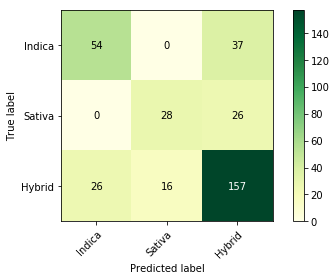

In [63]:
clf = svm.SVC(kernel='linear')
clf.fit(scaled_data_train, y_train)
y_pred=clf.predict(scaled_data_test)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plt.figure(figsize=(10,6))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('SVMmtx.png')
print_metrics(y_test,y_pred)

              precision    recall  f1-score   support

      indica       0.00      0.00      0.00        91
      satica       0.00      0.00      0.00        54
      hybrid       0.58      1.00      0.73       199

   micro avg       0.58      0.58      0.58       344
   macro avg       0.19      0.33      0.24       344
weighted avg       0.33      0.58      0.42       344

Predicted    2  All
True               
0           91   91
1           54   54
2          199  199
All        344  344
Precision Score: [0.  0.  0.6]
Recall Score: [0. 0. 1.]
Accuracy Score: 0.5784883720930233
F1 Score: [0.  0.  0.7]


<Figure size 720x432 with 0 Axes>

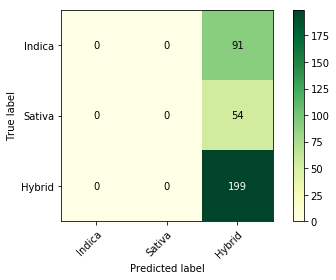

In [64]:
clf = svm.SVC(kernel='linear')
clf.fit(Xptrain, yptrain)
y_pred=clf.predict(Xptest)
print(classification_report(yptest,y_pred,target_names=['indica','satica','hybrid']))
plt.figure(figsize=(10,6))
plot_corr_matrix(yptest,y_pred,['Indica','Sativa','Hybrid'])
plt.savefig('SVMPCAmtx.png')
print_metrics(yptest,y_pred)

## Naive Bayes

In [218]:
from sklearn.naive_bayes import BernoulliNB
clf=BernoulliNB()
clf.fit(scaled_data_train, y_train)
y_pred=clf.predict(scaled_data_test)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))

              precision    recall  f1-score   support

      indica       0.64      0.66      0.65        91
      satica       0.47      0.65      0.54        54
      hybrid       0.71      0.63      0.67       199

   micro avg       0.64      0.64      0.64       344
   macro avg       0.61      0.65      0.62       344
weighted avg       0.66      0.64      0.64       344



              precision    recall  f1-score   support

      indica       0.47      0.87      0.61        91
      satica       0.30      0.93      0.45        54
      hybrid       0.43      0.02      0.03       199

   micro avg       0.38      0.38      0.38       344
   macro avg       0.40      0.60      0.36       344
weighted avg       0.42      0.38      0.25       344

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


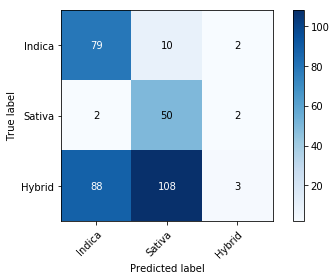

In [220]:
clf=GaussianNB()
clf.fit(scaled_data_train, y_train)
y_pred=clf.predict(scaled_data_test)
print(classification_report(y_test,y_pred,target_names=['indica','satica','hybrid']))
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

In [221]:
scaled_data_train=pd.DataFrame(scaled_data_train)
scaled_data_test=pd.DataFrame(scaled_data_test)

## Adaboost

In [222]:
clfa=AdaBoostClassifier()
clfa.fit(scaled_data_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [223]:
adaboost_train_preds = clfa.predict(scaled_data_train)
y_pred = clfa.predict(scaled_data_test)

Predicted   0   1    2  All
True                       
0          31   8   52   91
1          10   6   38   54
2          39  22  138  199
All        80  36  228  344


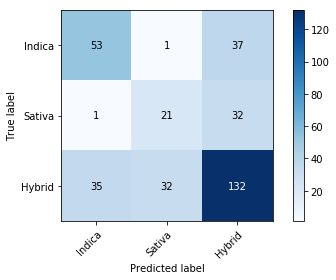

In [224]:
confusion_matrix(y_test,adaboost_test_preds)
plot_corr_matrix(y_test,y_pred,['Indica','Sativa','Hybrid'])

In [225]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59        91
           1       0.39      0.39      0.39        54
           2       0.66      0.66      0.66       199

   micro avg       0.60      0.60      0.60       344
   macro avg       0.55      0.54      0.55       344
weighted avg       0.60      0.60      0.60       344

